![Insper](https://github.com/danielscarvalho/Insper-DS-Dicas/blob/master/Insper-Logo.png?raw=true)

# Insper Pós-Graduação
## Programa Avançado em Data Science e Decisão [»](https://www.insper.edu.br/pos-graduacao/programas-avancados/programa-avancado-em-data-science-e-decisao/)


# Atividade Integradora
## Setup

### Dependências

In [1]:
import pandas as pd
import numpy as np
from dfply import *
import altair as alt
import missingno as msno
from ydata_profiling import ProfileReport
import matplotlib
import matplotlib.pyplot as plt 
import math
import seaborn as sns
from sklearn import linear_model
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import statsmodels.api as sm

c:\Users\Luiz\anaconda3\Lib\site-packages\numba\core\decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
c:\Users\Luiz\anaconda3\Lib\site-packages\visions\backends\shared\nan_handling.py:50: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @nb.jit


### Carregamento dos Dados

Leitura da base de dados e do dicionários de dados

In [2]:
data = pd.read_csv("cs_bisnode_panel.csv")
dicionario_de_dados_0 = pd.read_excel("bisnode_variable_names.xls", header=4)

Visualização inicial da base de dados

In [3]:
data.head()

,comp_id,begin,end,COGS,amort,curr_assets,curr_liab,extra_exp,extra_inc,extra_profit_loss,...,gender,origin,nace_main,ind2,ind,urban_m,region_m,founded_date,exit_date,labor_avg
0,1001034.0,2005-01-01,2005-12-31,NaN,692.592590,7266.666504,7574.074219,0.0,0.0,0.0,...,mix,Domestic,5630.0,56.0,3.0,1,Central,1990-11-19,NaN,NaN
1,1001034.0,2006-01-01,2006-12-31,NaN,603.703674,13122.222656,12211.111328,0.0,0.0,0.0,...,mix,Domestic,5630.0,56.0,3.0,1,Central,1990-11-19,NaN,NaN
2,1001034.0,2007-01-01,2007-12-31,NaN,425.925934,8196.295898,7800.000000,0.0,0.0,0.0,...,mix,Domestic,5630.0,56.0,3.0,1,Central,1990-11-19,NaN,NaN
3,1001034.0,2008-01-01,2008-12-31,NaN,300.000000,8485.185547,7781.481445,0.0,0.0,0.0,...,mix,Domestic,5630.0,56.0,3.0,1,Central,1990-11-19,NaN,NaN
4,1001034.0,2009-01-01,2009-12-31,NaN,207.407410,5137.037109,15300.000000,0.0,0.0,0.0,...,mix,Domestic,5630.0,56.0,3.0,1,Central,1990-11-19,NaN,0.083333


In [4]:
data.describe()

,comp_id,COGS,amort,curr_assets,curr_liab,extra_exp,extra_inc,extra_profit_loss,finished_prod,fixed_assets,...,ceo_count,foreign,female,birth_year,inoffice_days,nace_main,ind2,ind,urban_m,labor_avg
count,2.878290e+05,1.825700e+04,2.797890e+05,2.876980e+05,2.876980e+05,2.693000e+05,2.693000e+05,2.706260e+05,1.748500e+04,2.876980e+05,...,231402.000000,231402.000000,231402.000000,176011.000000,231402.000000,286791.000000,286791.000000,278060.000000,287829.000000,141297.000000
mean,1.540862e+11,4.601683e+05,2.353264e+04,2.209395e+05,1.742499e+05,1.521749e+03,3.754458e+03,2.229149e+03,1.056481e+05,3.393731e+05,...,1.254038,0.115653,0.255157,1964.902661,3205.323629,4858.231479,48.353062,2.692023,2.067075,1.009435
std,1.382424e+11,2.614149e+06,8.216668e+05,4.182020e+06,3.730357e+06,7.237342e+04,1.727794e+05,1.611169e+05,5.338053e+05,1.823176e+07,...,0.517837,0.308518,0.406538,11.546875,1880.553038,1250.012437,12.570550,0.512269,0.847473,4.771655
min,1.001034e+06,-8.445704e+05,-3.076704e+05,-5.555556e+05,-7.727111e+05,-4.902703e+05,-2.744074e+05,-6.181263e+06,0.000000e+00,-2.394226e+06,...,1.000000,0.000000,0.000000,1920.000000,1.000000,111.000000,1.000000,1.000000,1.000000,0.000000
25%,2.868635e+10,0.000000e+00,3.333333e+01,2.203704e+03,1.833333e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,1.000000,0.000000,0.000000,1956.000000,1775.000000,3314.000000,33.000000,2.000000,1.000000,0.090909
50%,1.152850e+11,7.040741e+03,7.814815e+02,9.592593e+03,1.049259e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.825926e+03,...,1.000000,0.000000,0.000000,1966.000000,2838.000000,5610.000000,56.000000,3.000000,2.000000,0.243056
75%,2.593958e+11,1.063000e+05,4.003704e+03,3.552130e+04,4.101852e+04,0.000000e+00,0.000000e+00,0.000000e+00,3.592592e+02,3.593982e+04,...,1.000000,0.000000,0.500000,1974.000000,4468.750000,5610.000000,56.000000,3.000000,3.000000,0.583333
max,4.641209e+11,9.499693e+07,1.820889e+08,1.299011e+09,1.683374e+09,1.704172e+07,7.233078e+07,7.233078e+07,1.803635e+07,7.940211e+09,...,15.000000,1.000000,1.000000,2016.000000,10983.000000,9609.000000,96.000000,3.000000,3.000000,219.333344


## Dicionário de dados
### Limpeza

Ao carregar o dicionário de dados a primeira coluna pega seu nome da quarta linha da tabela (argumento `header=4` acima). As outras três colunas são nomeadas abaixo.

In [5]:
dicionario_de_dados_1 = dicionario_de_dados_0.rename({'Unnamed: 1': 'description',
                                                      'Unnamed: 2': 'type',
                                                      'Unnamed: 3': 'footnote'},
                                                     axis=1)

In [6]:
dicionario_de_dados_1.columns

Index(['variable', 'description', 'type', 'footnote'], dtype='object')

Então, retiramos as linhas não relevantes para a análise, incluindo linhas totalmente em branco e uma linha com informação de versão da base de dados: 
 - `v 0.92. 2021-02-04`

In [7]:
dicionario_de_dados = dicionario_de_dados_1\
                       .drop(index=54)\
                       .dropna(how="all")\
                       .reset_index()\
                       .drop('index', axis='columns')

In [8]:
dicionario_de_dados.sample(5)

,variable,description,type,footnote
45,exit_date,Firm exit date,date,NaN
4,amort,amortization,numeric,(euros)
39,nace_main,"NACE industry code, 4 digits",categorical,NaN
14,inventories,inventories,numeric,(euros)
6,curr_liab,current liabilities,numeric,(euros)


## Dados faltantes
---

###  Visualização
Vamos verificar dados faltando do banco de dados:

Criação de função para analisar os dados faltantes.

In [9]:
def show_missing(df):
    """Return a Pandas dataframe describing the contents of a source dataframe including missing values."""
    
    variables = []
    dtypes = []
    count = []
    unique = []
    missing = []
    pc_missing = []
    
    for item in df.columns:
        variables.append(item)
        dtypes.append(df[item].dtype)
        count.append(len(df[item]))
        unique.append(len(df[item].unique()))
        missing.append(df[item].isna().sum())
        pc_missing.append(round((df[item].isna().sum() / len(df[item])) * 100, 2))

    output = pd.DataFrame({
        'variable': variables, 
        'dtype': dtypes,
        'count': count,
        'unique': unique,
        'missing': missing, 
        'pc_missing': pc_missing
    })    
        
    return output

Verificando dados com maior falta de informações:

In [10]:
missing_data = show_missing(data).sort_values('pc_missing', ascending=False, ignore_index = True)

index_full_data = list(missing_data[missing_data['missing']==0].index)

missing_data.drop(labels=index_full_data, axis='index', inplace=True)

missing_data.head(10)

,variable,dtype,count,unique,missing,pc_missing
0,D,float64,287829,1,287829,100.00
1,finished_prod,float64,287829,4207,270344,93.93
2,wages,float64,287829,13011,269846,93.75
3,COGS,float64,287829,9791,269572,93.66
4,net_exp_sales,float64,287829,7085,269572,93.66
5,net_dom_sales,float64,287829,15052,269572,93.66
6,exit_year,float64,287829,19,248970,86.50
7,exit_date,object,287829,2603,231649,80.48
8,labor_avg,float64,287829,5824,146532,50.91
9,birth_year,float64,287829,265,111818,38.85


In [11]:
missing_val_columns = missing_data['variable'][missing_data['pc_missing']>0]

<Axes: >

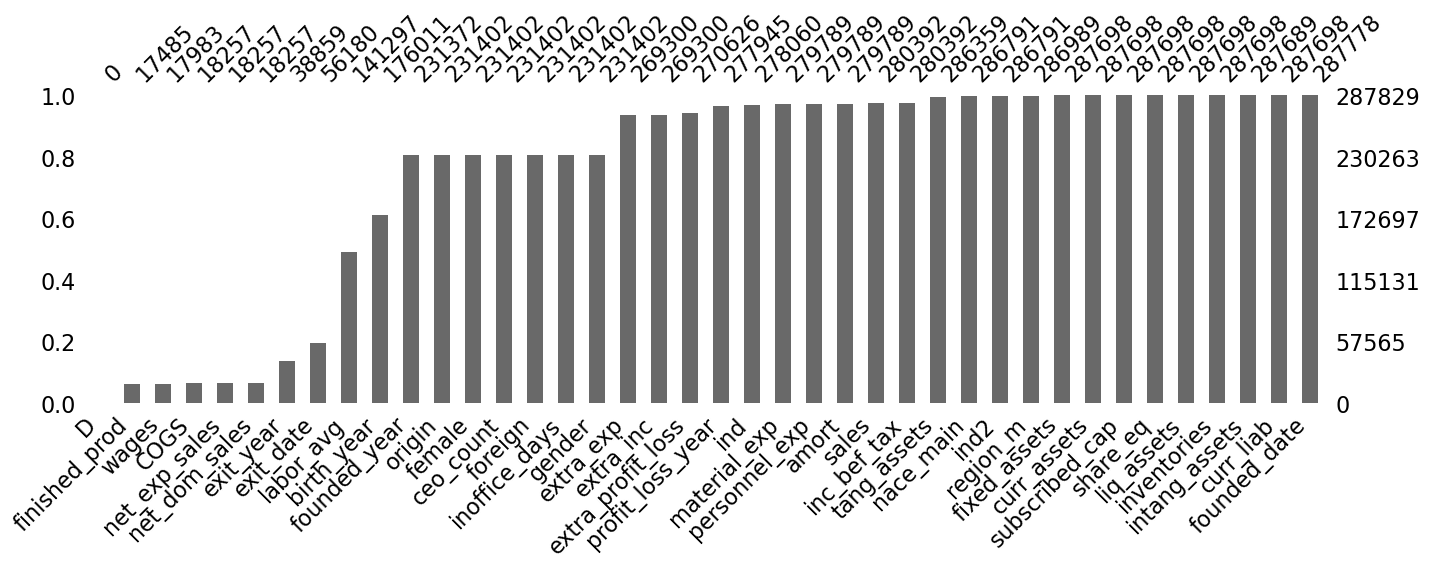

In [12]:
msno.bar(data[missing_val_columns], figsize=(16, 4))

### Colunas com poucos dados
Removemos aqui seis colunas tem mais de 90% de dados faltantes, removemos as colunas "begin" e "end" que contêm informação sobre o período a que os dados dizem respeito pois consideramos na análise essa mesma informação contida na variável "year". Removemos também as variáveis 'exit_year' e 'exit_data', visto que o encerrameto da empresa é definido com base na variável 'sales'.

In [13]:
columns_to_remove = ['COGS',
                     'finished_prod',
                     'net_dom_sales',
                     'net_exp_sales',
                     'wages',
                     'D',
                     'begin',
                     'end',
                     'exit_year',
                     'exit_date'] 

data.drop(columns=columns_to_remove, inplace=True)

data.columns

Index(['comp_id', 'amort', 'curr_assets', 'curr_liab', 'extra_exp',
       'extra_inc', 'extra_profit_loss', 'fixed_assets', 'inc_bef_tax',
       'intang_assets', 'inventories', 'liq_assets', 'material_exp',
       'personnel_exp', 'profit_loss_year', 'sales', 'share_eq',
       'subscribed_cap', 'tang_assets', 'balsheet_flag', 'balsheet_length',
       'balsheet_notfullyear', 'year', 'founded_year', 'ceo_count', 'foreign',
       'female', 'birth_year', 'inoffice_days', 'gender', 'origin',
       'nace_main', 'ind2', 'ind', 'urban_m', 'region_m', 'founded_date',
       'labor_avg'],
      dtype='object')

### "founded_year"
Aproveitamos para tratar aqui a variável "founded_year" que utilizamos mais à frente na criação da feature "company_age".

In [14]:
missing_data.loc[missing_data['variable'].isin(['founded_year','founded_date'])]

,variable,dtype,count,unique,missing,pc_missing
10,founded_year,float64,287829,39,56457,19.61
39,founded_date,object,287829,6363,51,0.02


Convertemos 'founde_date' para datetime.

In [15]:
data.dtypes['founded_date']

dtype('O')

In [16]:
data['founded_date'] = pd.to_datetime(data['founded_date'], format='%Y-%m-%d')

data['founded_date'].dtypes

dtype('<M8[ns]')

Utilizamos a variável "founded_date" (que tem uma menor proporção de valores faltantes) para preencher alguns dos valores faltantes em "founded_year" (que tem a granularidade desejada para a análise).

In [17]:
assert any(data.loc[(data['founded_date'].isna() & 
                     data['founded_year'].isna()),
                    'comp_id'].count() ==\
           missing_data.loc[missing_data['variable'] == 'founded_date', 'missing'])

As observações sem informação em "founded_date" também não tem informação para "founded_year" e são retiradas.

In [18]:
# Remove linhas onde 'founded_date' é NaN
data = data.dropna(subset=['founded_date'])

# Extrai o ano de 'founded_date' e substitui os valores ausentes em 'founded_year'
data['founded_year'] = data['founded_date'].dt.year

# Descarta a coluna 'founded_date', pois o ano de fundação da empresa é suficiente
data = data.drop(columns=['founded_date'])

### Checkpoint
Análise dos percentuais de missing após os tratamentos.

In [19]:
missing_data2 = show_missing(data).sort_values('pc_missing', ascending=False, ignore_index = True)

index_full_data = list(missing_data2[missing_data2['missing']==0].index)

missing_data2.drop(labels=index_full_data, axis='index', inplace=True)

missing_data2

,variable,dtype,count,unique,missing,pc_missing
0,labor_avg,float64,287778,5824,146488,50.90
1,birth_year,float64,287778,265,111778,38.84
2,gender,object,287778,4,56406,19.60
3,foreign,float64,287778,16,56406,19.60
4,female,float64,287778,15,56406,19.60
5,inoffice_days,float64,287778,11178,56406,19.60
6,origin,object,287778,4,56406,19.60
7,ceo_count,float64,287778,15,56406,19.60
8,extra_inc,float64,287778,8176,18526,6.44
9,extra_exp,float64,287778,4254,18526,6.44


### Colunas com dados quase completos

Aqui tratamos as colunas com 5% ou menos dados faltantes. Primeiramente checamos se esses dados estão faltando nas mesmas observações ou se estão distribuidos em observações diferentes.

In [20]:
# Lista de colunas com menos de 5% de dados ausentes

cols = list(missing_data2['variable'][missing_data2['pc_missing']<5.0])

# Verifica quais linhas possuem dados ausentes nessas colunas

missing_rows = data[cols].isnull().any(axis=1)      

# Calcula o percentual de linhas com dados ausentes

pc_missing_rows = 100 * missing_rows.sum() / len(data)

print(f'Percentual de linhas com dados ausentes em pelo menos uma das colunas mencionadas: {pc_missing_rows:.2f}%')

Percentual de linhas com dados ausentes em pelo menos uma das colunas mencionadas: 10.09%


In [21]:
# Remove variáveis com menos de 5% de dados ausentes
removable_na_columns = list(missing_data2['variable'][missing_data2['pc_missing']<5.0])

data.dropna(subset=removable_na_columns, inplace=True)

Valores faltantes após os tratamentos.

In [22]:
missing_data_3 = show_missing(data).sort_values('pc_missing', ascending=False, ignore_index = True)

index_full_data = list(missing_data_3[missing_data_3['missing']==0].index)

missing_data_3.drop(labels=index_full_data, axis='index', inplace=True)

missing_data_3

,variable,dtype,count,unique,missing,pc_missing
0,labor_avg,float64,258734,5385,132558,51.23
1,birth_year,float64,258734,261,100053,38.67
2,origin,object,258734,4,50571,19.55
3,ceo_count,float64,258734,15,50571,19.55
4,foreign,float64,258734,16,50571,19.55
5,female,float64,258734,15,50571,19.55
6,gender,object,258734,4,50571,19.55
7,inoffice_days,float64,258734,10876,50571,19.55
23,extra_exp,float64,258734,4070,5,0.00
24,extra_inc,float64,258734,7908,5,0.00


<Axes: >

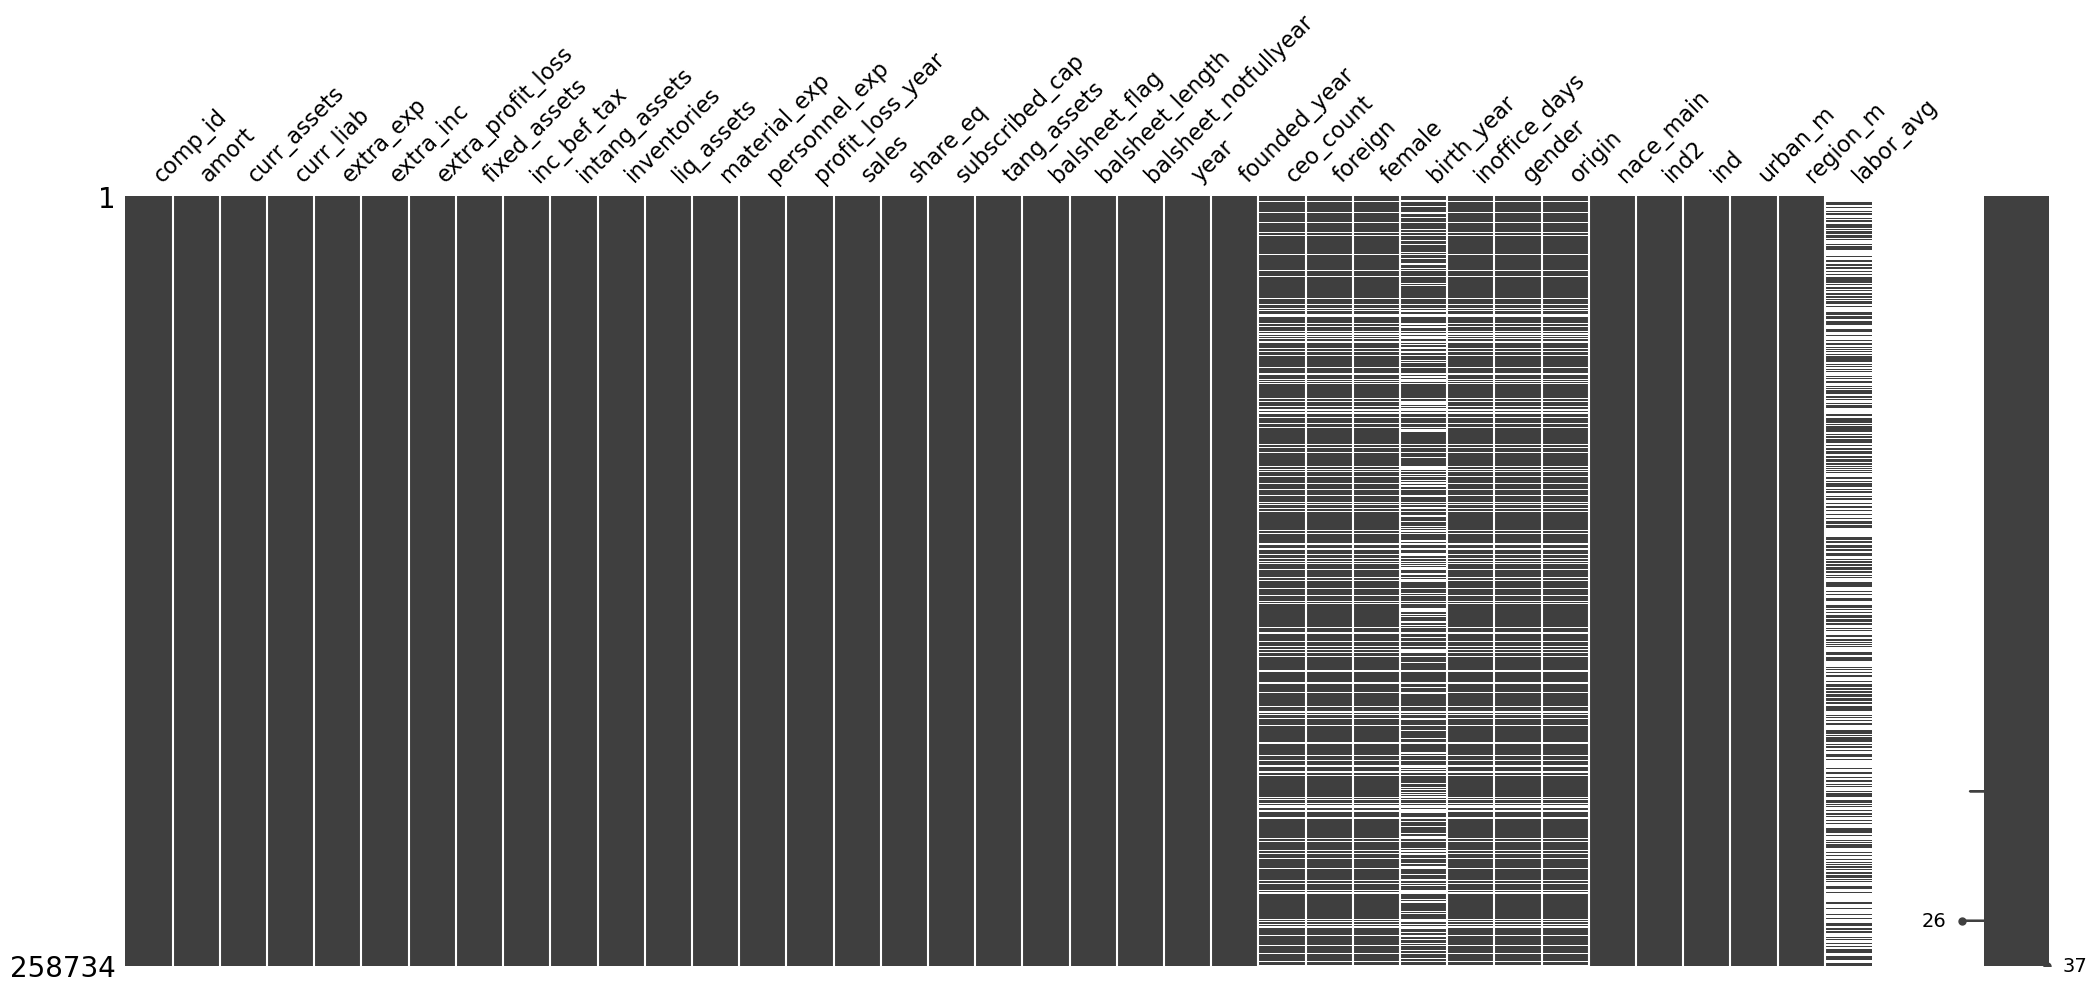

In [23]:
msno.matrix(data)

A tabela mostra 6 variáveis com cerca de 20% de dados faltantes nesse ponto da análise, e o gráfico indica que essa ausência de dados coincide nas mesmas observações. Optamos por deixar essas observações apesar da coincidência de dados faltantes, e tratar as faltas mais abaixo.

## Tratamento de demais variáveis com MICE

Os demais valores ausentes são preenchidos utilizando o método MICE (Multiple Imputation by Chained Equations) com a biblioteca 'IterativeImputer' do sklearn. 



In [27]:
df_mice = data.copy()
df_mice.head()

,comp_id,amort,curr_assets,curr_liab,extra_exp,extra_inc,extra_profit_loss,fixed_assets,inc_bef_tax,intang_assets,...,birth_year,inoffice_days,gender,origin,nace_main,ind2,ind,urban_m,region_m,labor_avg
0,1001034.0,692.592590,7266.666504,7574.074219,0.0,0.0,0.0,1229.629639,218.518524,0.0,...,1968.0,5686.5,mix,Domestic,5630.0,56.0,3.0,1,Central,NaN
1,1001034.0,603.703674,13122.222656,12211.111328,0.0,0.0,0.0,725.925903,996.296326,0.0,...,1968.0,5686.5,mix,Domestic,5630.0,56.0,3.0,1,Central,NaN
2,1001034.0,425.925934,8196.295898,7800.000000,0.0,0.0,0.0,1322.222168,570.370361,0.0,...,1968.0,5686.5,mix,Domestic,5630.0,56.0,3.0,1,Central,NaN
3,1001034.0,300.000000,8485.185547,7781.481445,0.0,0.0,0.0,1022.222229,714.814819,0.0,...,1968.0,5686.5,mix,Domestic,5630.0,56.0,3.0,1,Central,NaN
4,1001034.0,207.407410,5137.037109,15300.000000,0.0,0.0,0.0,814.814819,-11044.444336,0.0,...,1968.0,5686.5,mix,Domestic,5630.0,56.0,3.0,1,Central,0.083333


In [28]:
# Copia o df_mice para criar variáveis dummy
df_mice2 = df_mice.copy()
df_mice2 = pd.get_dummies(df_mice2)

In [29]:
# Define Input de MICE e preenche NaN 

mice_imputer = IterativeImputer(estimator=linear_model.BayesianRidge(), n_nearest_features=None, imputation_order='ascending')
df_mice_imputed = pd.DataFrame(mice_imputer.fit_transform(df_mice2), columns=df_mice2.columns)

In [30]:
df_mice_imputed.head()

,comp_id,amort,curr_assets,curr_liab,extra_exp,extra_inc,extra_profit_loss,fixed_assets,inc_bef_tax,intang_assets,...,labor_avg,gender_female,gender_male,gender_mix,origin_Domestic,origin_Foreign,origin_mix,region_m_Central,region_m_East,region_m_West
0,1001034.0,692.592590,7266.666504,7574.074219,0.0,0.0,0.0,1229.629639,218.518524,0.0,...,0.597375,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
1,1001034.0,603.703674,13122.222656,12211.111328,0.0,0.0,0.0,725.925903,996.296326,0.0,...,0.586088,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
2,1001034.0,425.925934,8196.295898,7800.000000,0.0,0.0,0.0,1322.222168,570.370361,0.0,...,0.558625,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
3,1001034.0,300.000000,8485.185547,7781.481445,0.0,0.0,0.0,1022.222229,714.814819,0.0,...,0.536736,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
4,1001034.0,207.407410,5137.037109,15300.000000,0.0,0.0,0.0,814.814819,-11044.444336,0.0,...,0.083333,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0


In [31]:
missing_data_3 = show_missing(df_mice_imputed).sort_values("pc_missing", ascending=False, ignore_index = True)

index_full_data_3 = list(missing_data_3[missing_data_3["missing"]==0].index)

missing_data_3.drop(labels=index_full_data_3, axis="index", inplace=True)

missing_data_3

,variable,dtype,count,unique,missing,pc_missing


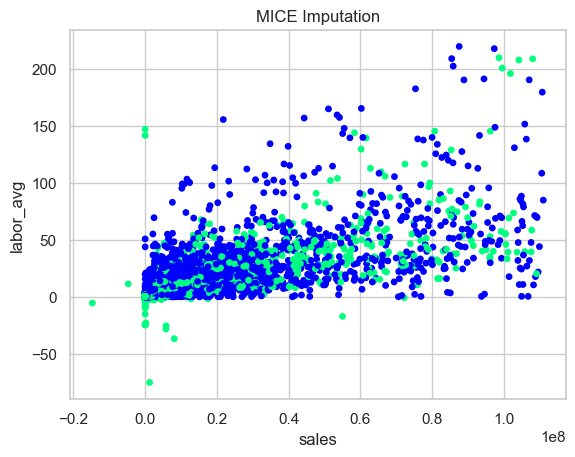

In [32]:
# Verifica dados imputados 

# MICE imputação
fig = plt.Figure()
null_values = data['labor_avg'].isnull() 
fig = df_mice_imputed.plot(x='sales', y='labor_avg', kind='scatter',
                           c=null_values, cmap='winter', s = 15,
                           title='MICE Imputation', colorbar=False)

In [33]:
data.columns

Index(['comp_id', 'amort', 'curr_assets', 'curr_liab', 'extra_exp',
       'extra_inc', 'extra_profit_loss', 'fixed_assets', 'inc_bef_tax',
       'intang_assets', 'inventories', 'liq_assets', 'material_exp',
       'personnel_exp', 'profit_loss_year', 'sales', 'share_eq',
       'subscribed_cap', 'tang_assets', 'balsheet_flag', 'balsheet_length',
       'balsheet_notfullyear', 'year', 'founded_year', 'ceo_count', 'foreign',
       'female', 'birth_year', 'inoffice_days', 'gender', 'origin',
       'nace_main', 'ind2', 'ind', 'urban_m', 'region_m', 'labor_avg'],
      dtype='object')

In [34]:
df_mice_imputed.columns

Index(['comp_id', 'amort', 'curr_assets', 'curr_liab', 'extra_exp',
       'extra_inc', 'extra_profit_loss', 'fixed_assets', 'inc_bef_tax',
       'intang_assets', 'inventories', 'liq_assets', 'material_exp',
       'personnel_exp', 'profit_loss_year', 'sales', 'share_eq',
       'subscribed_cap', 'tang_assets', 'balsheet_flag', 'balsheet_length',
       'balsheet_notfullyear', 'year', 'founded_year', 'ceo_count', 'foreign',
       'female', 'birth_year', 'inoffice_days', 'nace_main', 'ind2', 'ind',
       'urban_m', 'labor_avg', 'gender_female', 'gender_male', 'gender_mix',
       'origin_Domestic', 'origin_Foreign', 'origin_mix', 'region_m_Central',
       'region_m_East', 'region_m_West'],
      dtype='object')

Reverte o processo de pd.get_dummies com base no df_mice_imputed

In [35]:
# Dicionário que contém as colunas originais e suas respectivas colunas dummy
categorical_cols_transformed = {
    'gender': [col for col in df_mice_imputed.columns if 'gender_' in col],
    'origin': [col for col in df_mice_imputed.columns if 'origin_' in col],
    'region_m': [col for col in df_mice_imputed.columns if 'region_m_' in col]
}

# Para cada coluna original, encontra a coluna dummy com o valor mais alto (1) e restaura a coluna original
for original_col, dummies in categorical_cols_transformed.items():
    df_mice_imputed[original_col] = df_mice_imputed[dummies].idxmax(axis=1).str.replace(original_col + "_", "")
    df_mice_imputed.drop(dummies, axis=1, inplace=True)

In [36]:
df_mice_imputed.columns

Index(['comp_id', 'amort', 'curr_assets', 'curr_liab', 'extra_exp',
       'extra_inc', 'extra_profit_loss', 'fixed_assets', 'inc_bef_tax',
       'intang_assets', 'inventories', 'liq_assets', 'material_exp',
       'personnel_exp', 'profit_loss_year', 'sales', 'share_eq',
       'subscribed_cap', 'tang_assets', 'balsheet_flag', 'balsheet_length',
       'balsheet_notfullyear', 'year', 'founded_year', 'ceo_count', 'foreign',
       'female', 'birth_year', 'inoffice_days', 'nace_main', 'ind2', 'ind',
       'urban_m', 'labor_avg', 'gender', 'origin', 'region_m'],
      dtype='object')

## Converter colunas nace_main, ind2 e ind para variáveis categóricas

In [37]:
# Conferindo os valores das colunas
print("Valores únicos em 'nace_main':")
print(data['nace_main'].unique())

print("\nValores únicos em 'ind2':")
print(data['ind2'].unique())

print("\nValores únicos em 'ind':")
print(data['ind'].unique())

Valores únicos em 'nace_main':
[5630. 5610. 2711. 3314. 5510. 3312. 2920. 3320. 2752. 2732. 3313. 2829.
 5629. 3020. 2899. 3319. 2740. 5590. 5520. 2821. 2932. 2825. 2790. 2830.
 2630. 2660. 3316. 2651. 2822. 2611. 5621. 3091. 3011. 2620. 2670. 5530.
 3030. 2893. 3012. 2712. 2910. 2811. 2931. 2841. 2894. 2814. 2813. 2849.
 2823. 2612. 3092. 2640. 2733. 2892. 3315. 2812. 2815. 2751. 2891. 2895.
 3311. 2824. 2840. 2896. 2652. 3317. 2731. 2720. 3099. 2680. 5600. 5500.
 3040.]

Valores únicos em 'ind2':
[56. 27. 33. 55. 29. 28. 30. 26.]

Valores únicos em 'ind':
[3. 2. 1.]


In [38]:
# Verificando os tipos das colunas antes da conversão
print("Tipos das colunas antes da conversão:")
print(data[['nace_main', 'ind2', 'ind']].dtypes)

Tipos das colunas antes da conversão:
nace_main    float64
ind2         float64
ind          float64
dtype: object


In [39]:
# Convertendo as colunas em categóricas
data['nace_main'] = data['nace_main'].astype('category')
data['ind2'] = data['ind2'].astype('category')
data['ind'] = data['ind'].astype('category')
print(data[['nace_main', 'ind2', 'ind']].dtypes)

nace_main    category
ind2         category
ind          category
dtype: object


## Feature Engineering
---

### Variável Dependente - Inatividade da Empresa
Chamamos "inativas" aquelas empresas que não apresentam vendas nos dois anos seguintes ao ano observado.\
**Nota:** ativa = 0, inativa = 1

In [40]:
# Ordena o DataFrame por empresa e ano
df_mice_imputed.sort_values(by=['comp_id', 'year'], inplace=True)

# Cria colunas deslocadas para checar vendas nos dois anos seguintes
conditions_x1 = [((df_mice_imputed['comp_id'] == df_mice_imputed['comp_id'].shift(-1)) &
                  (df_mice_imputed['year'] == df_mice_imputed['year'].shift(-1) - 1)),

                 ((df_mice_imputed['comp_id'] != df_mice_imputed['comp_id'].shift(-1)) |
                  df_mice_imputed['year'] != df_mice_imputed['year'].shift(-1))]

values_x1 = [df_mice_imputed['sales'].shift(-1),
             np.nan]

df_mice_imputed['sales_x1'] = pd.Series(np.select(conditions_x1, values_x1)).fillna(0)


conditions_x2 = [
    ((df_mice_imputed['comp_id'] == df_mice_imputed['comp_id'].shift(-1)) &   
     (df_mice_imputed['year'] == df_mice_imputed['year'].shift(-1) - 2)),

    ((df_mice_imputed['comp_id'] == df_mice_imputed['comp_id'].shift(-2)) &
     (df_mice_imputed['year'] == df_mice_imputed['year'].shift(-2) - 2)),

    True
]

values_x2 = [df_mice_imputed['sales'].shift(-1),
             df_mice_imputed['sales'].shift(-2),
             np.nan]

df_mice_imputed['sales_x2'] = pd.Series(np.select(conditions_x2, values_x2)).fillna(0)


# Define condicao usada para identificar empresas que pararam de operar:
#  - sem vendas por mais de 2 anos
condition = ((df_mice_imputed['sales_x1'] == 0) & (df_mice_imputed['sales_x2'] == 0)) 

# Create a new 'dependente' column with 1 for ceased companies and 0 otherwise
df_mice_imputed['fechado'] = condition.astype(int)

Vamos conferir os valores da variavel dependente para algumas empresas do dataframe:

In [41]:
# lista de colunas para avaliação
check_list = ['comp_id', 'year', 'sales', 'sales_x1', 'sales_x2', 'fechado']

filtro = df_mice_imputed[check_list]
filtro_sub = filtro[(filtro['comp_id'] == 464021159936) | (filtro['comp_id'] == 1001541)]

filtro_sub

,comp_id,year,sales,sales_x1,sales_x2,fechado
11,1.001541e+06,2009.0,925.925903,0.000000,0.000000,1
12,1.001541e+06,2010.0,0.000000,0.000000,1203.703735,0
13,1.001541e+06,2011.0,0.000000,1203.703735,5555.555664,0
14,1.001541e+06,2012.0,1203.703735,5555.555664,4888.888672,0
15,1.001541e+06,2013.0,5555.555664,4888.888672,4888.888672,0
16,1.001541e+06,2014.0,4888.888672,4888.888672,0.000000,0
17,1.001541e+06,2015.0,4888.888672,0.000000,0.000000,1
258693,4.640212e+11,2007.0,40677.777344,66507.406250,71685.187500,0
258694,4.640212e+11,2008.0,66507.406250,71685.187500,29374.074219,0
258695,4.640212e+11,2009.0,71685.187500,29374.074219,50474.074219,0


In [42]:
# Remodela os dados de vendas para tratar valores negativos
df_mice_imputed['sales'] = np.where(df_mice_imputed['sales']<0, 0, df_mice_imputed['sales'])

df_mice_imputed['fechado'] = condition.astype(int)

In [43]:
df_mice_imputed[check_list].describe()

,comp_id,year,sales,sales_x1,sales_x2,fechado
count,2.587340e+05,258734.000000,2.587340e+05,2.587340e+05,2.587340e+05,258734.000000
mean,1.540171e+11,2010.448352,4.731916e+05,4.174101e+05,3.663222e+05,0.277358
std,1.382659e+11,3.066267,3.775402e+06,3.478152e+06,3.251653e+06,0.447696
min,1.001034e+06,2005.000000,0.000000e+00,-4.730166e+06,-2.553889e+05,0.000000
25%,2.857290e+10,2008.000000,4.744444e+03,0.000000e+00,0.000000e+00,0.000000
50%,1.153078e+11,2011.000000,3.042222e+04,2.022963e+04,7.462963e+03,0.000000
75%,2.593265e+11,2013.000000,1.106694e+05,9.263241e+04,7.032129e+04,1.000000
max,4.641209e+11,2015.000000,1.110294e+08,1.110294e+08,1.110294e+08,1.000000


Vamos averiguar agora os anos em que as empresas tiveram atividade e inatividade:

In [44]:
# Converte "comp_id" para float antes de agrupar
df_mice_imputed['comp_id'] = df_mice_imputed['comp_id'].astype(float)

data_grouped = df_mice_imputed.groupby('comp_id')

# Conta anos de acompanhamento
comp_years = data_grouped['year'].count()

# Conta anos com vendas
sales_years = data_grouped.apply(lambda group: (group['sales'] > 0).sum())

# Conta anos sem vendas
no_sales_years = data_grouped.apply(lambda group: (group['sales'] == 0).sum())

# Conta anos de "inatividade"
inative_years = data_grouped.apply(lambda group: (group['fechado'] == 1).sum())

In [45]:
pd.options.display.float_format = '{:.1f}'.format

activity_df = pd.DataFrame({'Total years':comp_years,
                            'Sales years':sales_years, 
                            'No sales years':no_sales_years,
                            'Inative years':inative_years}).reset_index()

activity_df['comp_id'] = activity_df['comp_id'].astype(float)
activity_df.head()

,comp_id,Total years,Sales years,No sales years,Inative years
0,1001034.0,11,6,5,6
1,1001541.0,7,5,2,2
2,1002029.0,9,9,0,1
3,1003200.0,8,8,0,1
4,1004012.0,8,8,0,1


## Seleção de subset para análise
---
A modelagem é feita em cima de um subset dos dados com o objetivo de adicionar foco à analise e facilitar o processamento por estar trabalhando com menor volume de dados. O escopo desse subset pode ser adaptado iterativamente, atendendo a demandas que surjam na análise.

### Removendo dados do ano 2016
Registros do ano de 2016 são removidos do conjunto.

In [46]:
df_mice_imputed = df_mice_imputed[df_mice_imputed['year']!=2016].copy()
assert not any(df_mice_imputed["year"] == 2016)

### Ano

In [47]:
# Cria dataframe apenas com os dados do ano de 2012
data_2012 = df_mice_imputed[df_mice_imputed['year'] == 2012].copy()

assert data_2012.year.unique() == 2012 # verificando coluna de ano

### Tamanho da Empresa

In [48]:
# Considera apenas sales > 1000 e < 10000000
data_2012 = data_2012[(data_2012['sales'] > 1000) & (data_2012['sales'] < 10000000) ]

## Feature Engineering no Subset

### Assimetria
Nessa subsessão olhamos as medidas de assimetria das variáveis na nossa base. Para a presente análise tratamos apenas a variável "sales", criando outra variável a partir de seu logarítmo. A análise das demais variáveis é disponibilizada para interpretação e trabalho subsequente.

In [49]:
# Filtra apenas colunas numéricas para calcular assimetria
numeric_cols = data_2012.select_dtypes(include=[np.number]).columns # Avaliar a simetria das variáveis

# Avalia a simetria das colunas numéricas
skewness_values = data_2012[numeric_cols].skew()

# Ordena os valores de assimetria do maior para o menor
sorted_skewness_values = skewness_values.sort_values(ascending=False)

# Mostra os valores de assimetria ordenados
print(sorted_skewness_values)

extra_exp              143.9
extra_inc              131.7
extra_profit_loss       72.1
tang_assets             51.0
intang_assets           49.9
curr_liab               47.1
fixed_assets            44.0
inventories             39.4
subscribed_cap          34.8
sales_x2                30.4
amort                   27.1
liq_assets              20.9
balsheet_flag           20.8
share_eq                19.3
curr_assets             15.5
sales_x1                15.3
personnel_exp           12.2
labor_avg               10.1
material_exp             8.2
sales                    7.4
balsheet_notfullyear     3.3
fechado                  2.5
foreign                  2.1
ceo_count                1.8
inoffice_days            1.1
female                   0.9
comp_id                  0.7
year                     0.0
urban_m                 -0.2
birth_year              -0.2
founded_year            -0.5
nace_main               -1.0
ind2                    -1.0
ind                     -1.3
balsheet_lengt

In [50]:
# Identifica colunas com assimetria significativamente diferente de zero
cols_to_transform = skewness_values[skewness_values.abs() > 0.5].index
print(cols_to_transform)

Index(['comp_id', 'amort', 'curr_assets', 'curr_liab', 'extra_exp',
       'extra_inc', 'extra_profit_loss', 'fixed_assets', 'inc_bef_tax',
       'intang_assets', 'inventories', 'liq_assets', 'material_exp',
       'personnel_exp', 'profit_loss_year', 'sales', 'share_eq',
       'subscribed_cap', 'tang_assets', 'balsheet_flag', 'balsheet_length',
       'balsheet_notfullyear', 'founded_year', 'ceo_count', 'foreign',
       'female', 'inoffice_days', 'nace_main', 'ind2', 'ind', 'labor_avg',
       'sales_x1', 'sales_x2', 'fechado'],
      dtype='object')


Nas estatísticas descritivas abaixo, observa-se que a média é maior que o terceiro quartil, indicando uma distribuição bastante assimétrica. Criamos então uma coluna com o logarítmo de "sales" para auxiliar na análise.

In [51]:
print(data_2012['sales'].describe())

count     20952.0
mean     229374.2
std      768238.4
min        1003.7
25%       14364.8
50%       41722.2
75%      129792.6
max     9989311.0
Name: sales, dtype: float64


A coluna log_sales mostra que, embora muitas empresas tenham vendas relativamente baixas (indicado por um logaritmo de vendas próximo ou igual a zero), há empresas que se destacam com vendas substancialmente mais altas.

In [52]:
# Função para criar coluna com logaritmo da coluna argumento
def criar_log(data_set, col):
    new_col = 'log_' + col
    data_set.loc[:,new_col] = data_set.loc[:,col]\
                                            .apply(lambda x: math.log(x)\
                                                   if x > 0\
                                                   else 0) 

In [53]:
criar_log(data_2012, 'sales')
data_2012.log_sales.describe()

count   20952.0
mean       10.7
std         1.7
min         6.9
25%         9.6
50%        10.6
75%        11.8
max        16.1
Name: log_sales, dtype: float64

A descrição acima mostra valores mais simétricos para o logarítmo de "sales", quando comparado com "sales".

#### "sales" vs "log_sales"

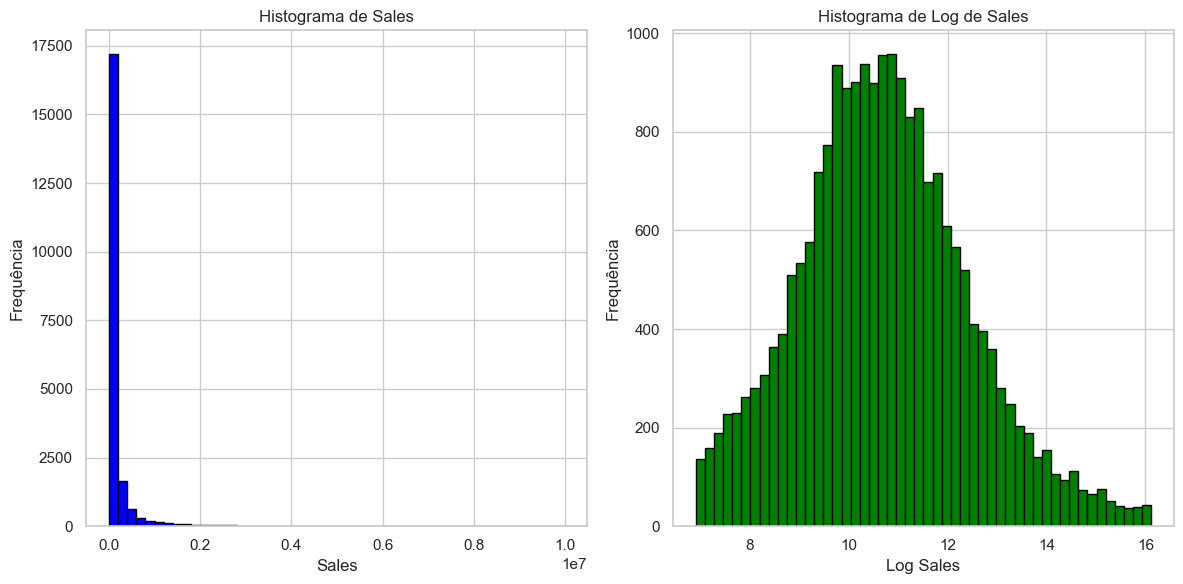

In [54]:
# Cria histogramas
plt.figure(figsize=(12, 6))

# Histograma de sales
plt.subplot(1, 2, 1)
plt.hist(data_2012['sales'], bins=50, color='blue', edgecolor='black')
plt.title('Histograma de Sales')
plt.xlabel('Sales')
plt.ylabel('Frequência')

# Histograma de log_sales
plt.subplot(1, 2, 2)
plt.hist(data_2012['log_sales'], bins=50, color='green', edgecolor='black')
plt.title('Histograma de Log de Sales')
plt.xlabel('Log Sales')
plt.ylabel('Frequência')

plt.tight_layout()
plt.show()


#### Idade da Empresa

In [55]:
data_2012['company_age'] = 2012 - data_2012['founded_year']

#### Outras Features

A fim de aprimorar a precisão e eficácia de nosso modelo, estamos considerando a introdução de novas variáveis explanatórias. A motivação por trás dessa decisão é explorar a possibilidade de que certas variáveis, ainda não incluídas em nosso modelo, possam ter um impacto significativo no erro do modelo. Ao identificar e incorporar essas variáveis potencialmente influentes, esperamos não apenas reduzir o erro, mas também aumentar a robustez do modelo, tornando suas previsões mais confiáveis e precisas. Nos próximos passos, avaliaremos cada uma dessas variáveis, sua relevância e a maneira como elas podem ser integradas ao modelo existente.

In [56]:
# Definir função para que, se o denominador for igual a 0, retornar zero
def safe_divide(numerator, denominator, default_value=0.0):
    if denominator == 0:
        return default_value
    return numerator / denominator

# Ajustar as novas variáveis com safe division 
data_2012["current_ratio"] = data_2012.apply(lambda row: safe_divide(row["curr_assets"], row["curr_liab"]), axis=1)
data_2012["profit_margin"] = data_2012.apply(lambda row: safe_divide(row["profit_loss_year"], row["sales"]), axis=1)
data_2012["debt_equity_ratio"] = data_2012.apply(lambda row: safe_divide((row["liq_assets"] - row["curr_liab"]), row["share_eq"]), axis=1)
data_2012["asset_turnover"] = data_2012.apply(lambda row: safe_divide(row["sales"], (row["curr_assets"] + row["fixed_assets"])), axis=1)

# Exibindo as primeiras linhas do df atualizado com as novas variáveis
data_2012[["current_ratio", "profit_margin", "debt_equity_ratio", "asset_turnover"]].head()

,current_ratio,profit_margin,debt_equity_ratio,asset_turnover
14,7.4,-6.4,0.0,0.0
23,1.7,0.0,-1.1,5.0
34,0.0,-0.8,0.5,125.3
54,8.5,0.2,0.1,0.4
65,24.2,-0.0,0.0,0.4


### Liquidez

A razão corrente (current_ratio), um indicador de liquidez, mede a capacidade de uma empresa de pagar suas obrigações de curto prazo usando ativos de curto prazo. Empresas com baixa liquidez podem ter dificuldades em cumprir suas obrigações financeiras imediatas, o que pode levar a problemas financeiros e aumentar o risco de encerramento no curto prazo.

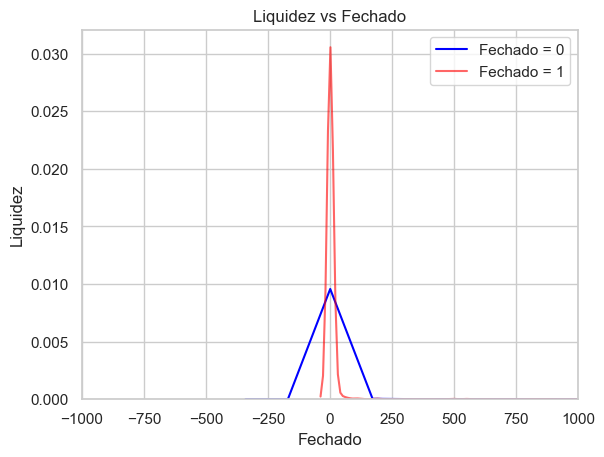

In [57]:
# Criando o kdeplot do giro de ativos, separado por 'fechado'

sns.kdeplot(data_2012["current_ratio"][data_2012['fechado'] == 0], color='blue', label='Fechado = 0')
sns.kdeplot(data_2012["current_ratio"][data_2012['fechado'] == 1], color='red', label='Fechado = 1', alpha=0.6)

# Definindo o título e os labels dos eixos
plt.title('Liquidez vs Fechado')
plt.xlabel('Fechado')
plt.ylabel('Liquidez')
plt.legend()
plt.xlim(-1000, 1000)  # Definindo o limite para o eixo x

# Mostrando o gráfico
plt.show()

### Margem de lucro

A Margem de Lucro mede a porcentagem de lucro que uma empresa obtém de suas vendas. Empresas com margens de lucro baixas podem ter dificuldades em absorver choques financeiros ou econômicos. Uma margem de lucro consistentemente baixa pode indicar problemas operacionais ou de eficiência, aumentando o risco de a empresa fechar no futuro.

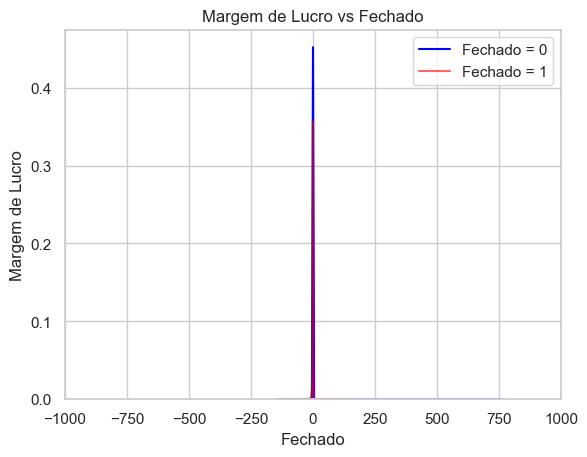

In [58]:
# Criando o boxplot da margem de lucro, separado por 'fechado'

sns.kdeplot(data_2012["profit_margin"][data_2012['fechado'] == 0], color='blue', label='Fechado = 0')
sns.kdeplot(data_2012["profit_margin"][data_2012['fechado'] == 1], color='red', label='Fechado = 1', alpha=0.6)


# Definindo o título e os labels dos eixos
plt.title('Margem de Lucro vs Fechado')
plt.xlabel('Fechado')
plt.ylabel('Margem de Lucro')
plt.legend()
plt.xlim(-1000, 1000)  # Definindo o limite para o eixo x

# Mostrando o gráfico
plt.show()

### Relação Dívida/Patrimônio Líquido

A Relação Dívida/Patrimônio Líquido indica quanto de financiamento a empresa obteve por dívida em relação ao seu patrimônio líquido. Uma alta relação pode sugerir que a empresa está excessivamente endividada, o que pode aumentar o risco financeiro. Empresas altamente endividadas podem enfrentar desafios em cumprir suas obrigações, especialmente em tempos de instabilidade econômica, elevando o risco de encerramento.

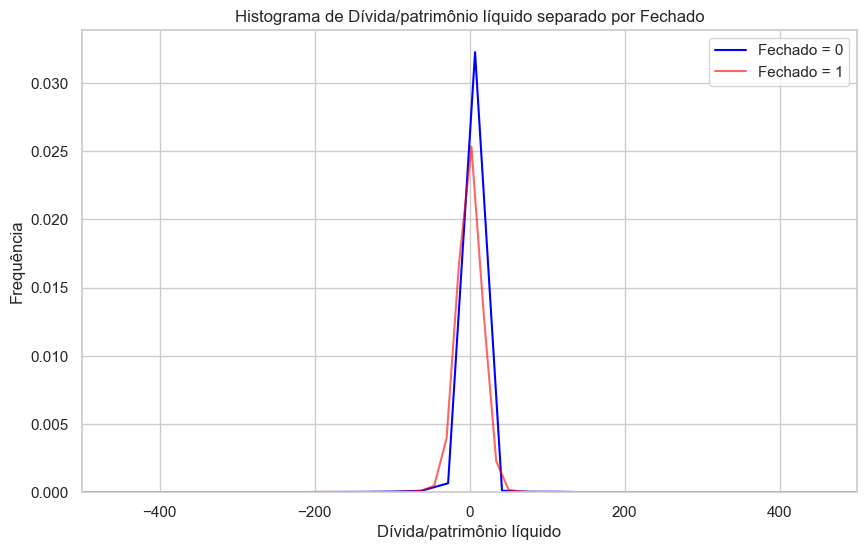

In [59]:
# Criando histogramas sobrepostos para comparar a variável Dívida/patrimônio líquido para os valores de fechado 0 e 1
plt.figure(figsize=(10, 6))

sns.kdeplot(data_2012["debt_equity_ratio"][data_2012['fechado'] == 0], color='blue', label='Fechado = 0')
sns.kdeplot(data_2012["debt_equity_ratio"][data_2012['fechado'] == 1], color='red', label='Fechado = 1', alpha=0.6)

# Definindo o título, os labels dos eixos e a legenda
plt.title('Histograma de Dívida/patrimônio líquido separado por Fechado')
plt.xlabel('Dívida/patrimônio líquido')
plt.ylabel('Frequência')
plt.legend()
plt.xlim(-500, 500)  # Definindo o limite para o eixo x

# Mostrando o gráfico
plt.show()

### Giro de Ativos

O Giro de Ativos mede a eficiência com que a empresa utiliza seus ativos para gerar vendas. Um giro de ativos baixo pode indicar ineficiência na utilização dos ativos. Empresas que não utilizam eficientemente seus ativos podem enfrentar dificuldades de crescimento e rentabilidade, o que pode influenciar negativamente sua viabilidade a longo prazo.

c:\Users\Luiz\anaconda3\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


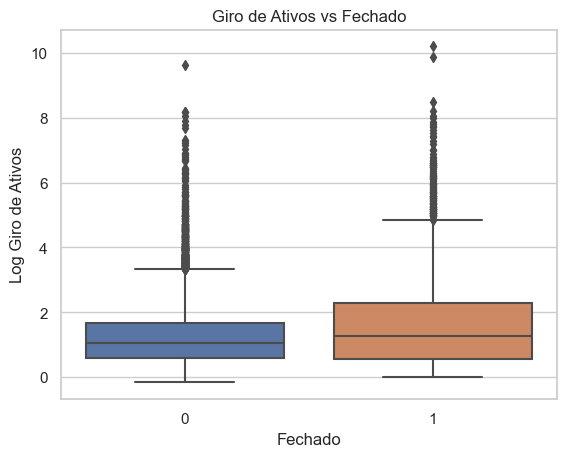

In [60]:
# Criando o boxplot da margem de lucro, separado por 'fechado'
sns.boxplot(x=data_2012['fechado'], y=np.log1p(data_2012["asset_turnover"]))

# Definindo o título e os labels dos eixos
plt.title('Giro de Ativos vs Fechado')
plt.xlabel('Fechado')
plt.ylabel('Log Giro de Ativos')

# Mostrando o gráfico
plt.show()

## Limpeza de variáveis provisórias
As variáveis "sales_x1" e "sales_x2" foram usadas na criação da variável dependente mas não são apropriadas para entrarem no modelo (constituiriam um data leak).
Como filtramos pelo ano de 2012, tambem não usaremos a variável "year" na modelagem.

In [61]:
data_2012 = data_2012.drop(columns=['sales_x1','sales_x2', 'year'])

## Matriz de correlação

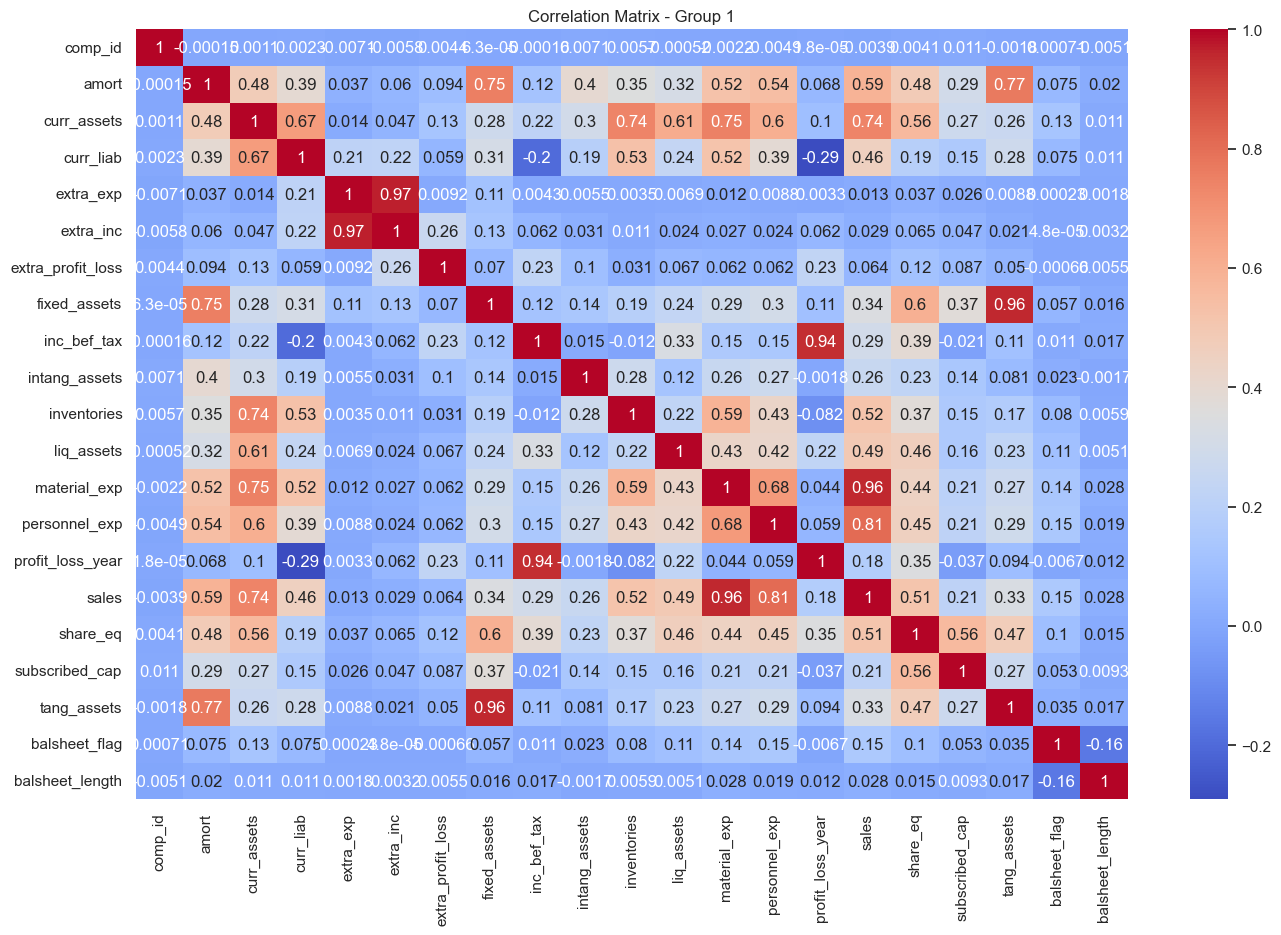

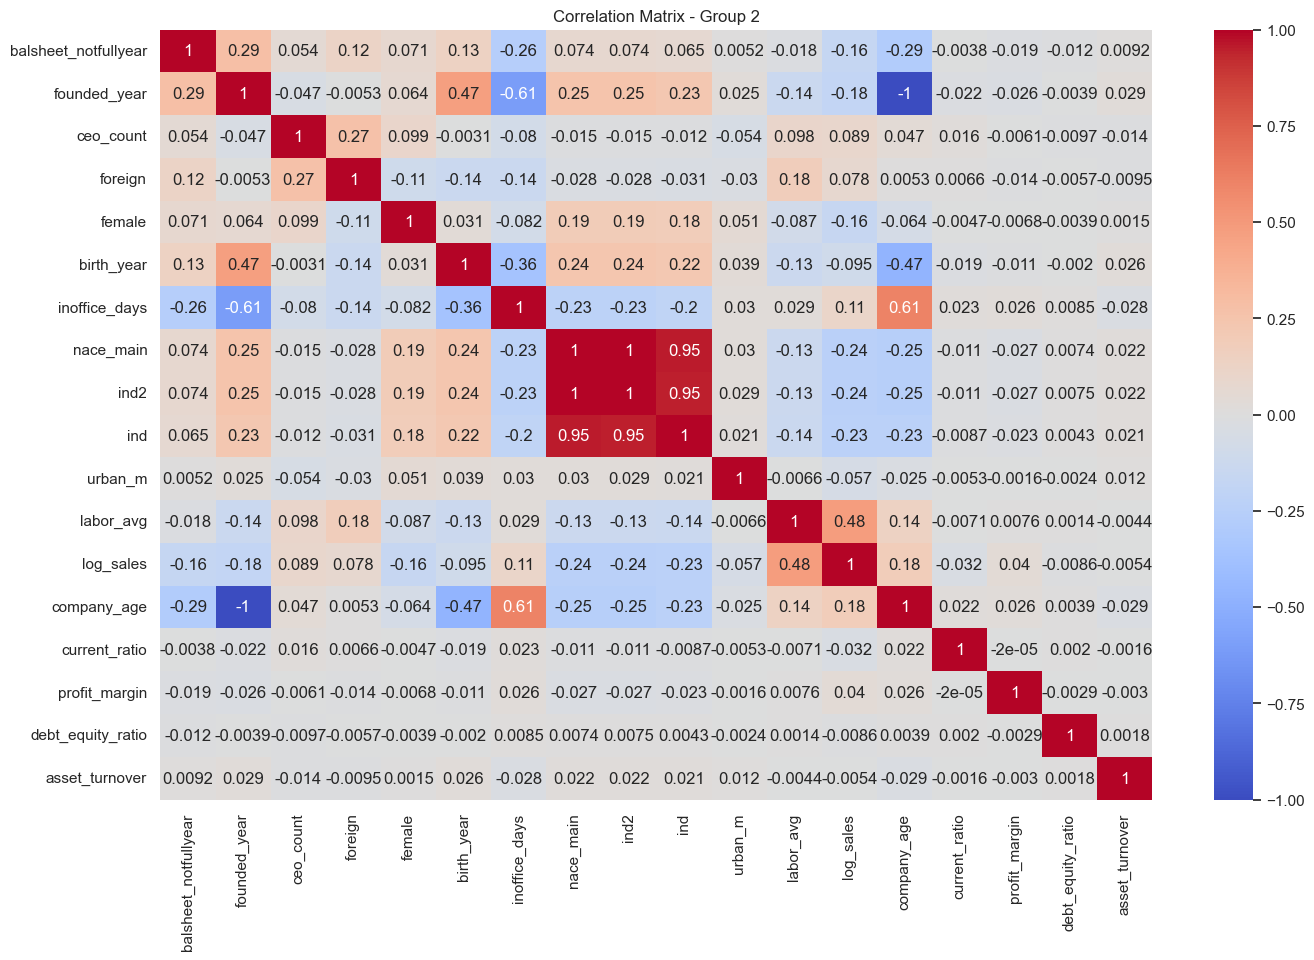

In [62]:
# Lista todas as colunas exceto "dependente"
cols = [col for col in data_2012.columns if col != 'fechado']

# Dividi as colunas em dois grupos
half = len(cols) // 2
group1 = cols[:half] + ['fechado']
group2 = cols[half:] + ['fechado']

# Considera apenas colunas numéricas
group1 = [col for col in group1 if data_2012[col].dtype in ['int64', 'float64']]
group2 = [col for col in group2 if data_2012[col].dtype in ['int64', 'float64']]

# Cria as duas matrizes de correlação
correlation_matrix1 = data_2012[group1].corr()
correlation_matrix2 = data_2012[group2].corr()

# Visualiza a primeira matriz de correlação
plt.figure(figsize=(16,10))
sns.heatmap(correlation_matrix1, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix - Group 1')
plt.show()

# Visualiza a segunda matriz de correlação
plt.figure(figsize=(16,10))
sns.heatmap(correlation_matrix2, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix - Group 2')
plt.show()

In [63]:
missing_data_4 = show_missing(data_2012).sort_values("pc_missing", ascending=False, ignore_index = True)

#full_index = list(missing_data_4[missing_data_4["missing"]==0].index)

#missing_data_4.drop(labels=full_index, axis="index", inplace=True)

missing_data_4.sort_values(by="variable", ignore_index=True)

,variable,dtype,count,unique,missing,pc_missing
0,amort,float64,20952,4714,0,0.0
1,asset_turnover,float64,20952,20883,0,0.0
2,balsheet_flag,float64,20952,2,0,0.0
3,balsheet_length,float64,20952,297,0,0.0
4,balsheet_notfullyear,float64,20952,2,0,0.0
5,birth_year,float64,20952,4901,0,0.0
6,ceo_count,float64,20952,1928,0,0.0
7,comp_id,float64,20952,20952,0,0.0
8,company_age,float64,20952,37,0,0.0
9,curr_assets,float64,20952,11332,0,0.0


Confirmamos que o banco de dados final gerado está completo, sem dados faltando através do processo de limpeza com alterações e remoções.

### Análise por agrupamento de variável dependente:
---

Vamos Agrupar as empresas marcadas pela variável dependente (fechada) para buscar visualizar algumas das tendências das empresas que fecharam no ano de 2012:

In [64]:
# Filtrando apenas colunas numéricas
numeric_data_2012 = data_2012.select_dtypes(include=[np.number])

# Agrupando pelo campo "fechado"
groups_2012 = numeric_data_2012.groupby(by="fechado")

# Realizando agregação
df_groups = groups_2012.agg(['mean', 'median'])

df_groups



comp_id                 amort        curr_assets          \
                  mean         median   mean median        mean  median   
fechado                                                                   
0       153980674907.0 115050463232.0 9961.8 1018.5    106762.6 12388.9   
1       150883496110.5 111458754560.0 2013.7  155.6     30314.5  3525.9   

        curr_liab         extra_exp         ... company_age         \
             mean  median      mean median  ...        mean median   
fechado                                     ...                      
0         90761.4 14214.8    1340.6    0.0  ...         8.9    8.0   
1         54390.9 13596.3     418.6    0.0  ...         6.1    3.0   

        current_ratio        profit_margin        debt_equity_ratio         \
                 mean median          mean median              mean median   
fechado                                                                      
0                10.6    1.1          -0.2    0.0              -1.4    0.1   
1                 6.3    0.3          -0.7   -0.3              -1.8    1.0   

        asset_turnover         
                  mean median  
fechado                        
0                  7.5    1.9  
1                 56.3    2.5  

[2 rows x 78 columns]

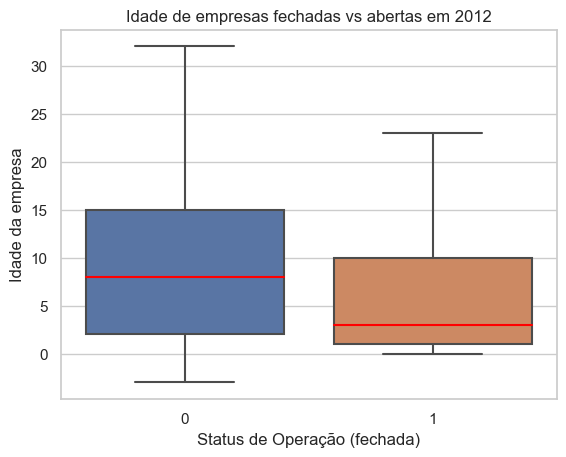

valores médios de idade da empresa:
fechado
0   8.9
1   6.1
Name: mean, dtype: float64


In [65]:
sns.boxplot(data=data_2012, x='fechado', y='company_age', 
            showfliers = False, medianprops = {"color":"red"})

# Configuração do gráfico:
plt.xlabel('Status de Operação (fechada)')
plt.ylabel('Idade da empresa')
plt.title('Idade de empresas fechadas vs abertas em 2012')

# Show the plot
plt.show()

print("valores médios de idade da empresa:")
print(df_groups["company_age"]['mean'])

In [66]:
def group_box(column, data = data_2012):
    ''' Funcao para rodar boxplot agrupado '''
    sns.boxplot(data=data, x='fechado', y=column, 
            showfliers = False, medianprops = {"color":"red"})

    # Configuração do gráfico:
    plt.xlabel('Status de Operação (fechada)')
    plt.ylabel(f'Valor variável "{column}"')
    plt.title('Análise agrupada {column}')

    # Show the plot
    plt.show()

    #print("valores médios da variável:")
    #print(df_groups[column]['mean'])


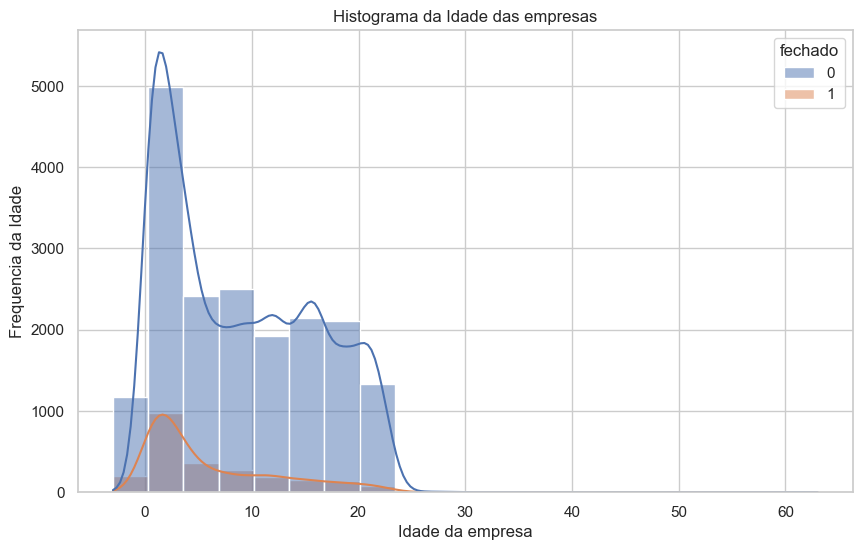

In [67]:
fig, ax = plt.subplots(figsize=(10, 6))

# Create histograms for each group using Seaborn
sns.histplot(data=data_2012, x='company_age', hue='fechado', bins=20, alpha=0.5, ax=ax, kde=True)

# Set labels and title
ax.set_xlabel('Idade da empresa')
ax.set_ylabel('Frequencia da Idade')
ax.set_title('Histograma da Idade das empresas')

# Show the plot
plt.show()

In [68]:

def group_hist(column, data=data_2012):
    ''' Funcao para gerar o histograma com linha de tendencia agrupado'''
    
    fig, ax = plt.subplots(figsize=(10, 6))

    # Create histograms for each group using Seaborn
    sns.histplot(data=data, x=column, hue='fechado', bins=20, alpha=0.5, ax=ax, kde=True)

    # Set labels and title
    ax.set_xlabel(f'valor da variável {column}')
    ax.set_ylabel(f'Frequência da variável {column}')
    ax.set_title(f'Histograma de {column}')

    # Show the plot
    plt.show()

O grupo de empresas abertas mostra cauda à direita mais substancial que as outras, indicando uma menor tendencia de empresas mais velhas fecharem relativo ao mesmo risco para empresas mais novas.

#### Amortização

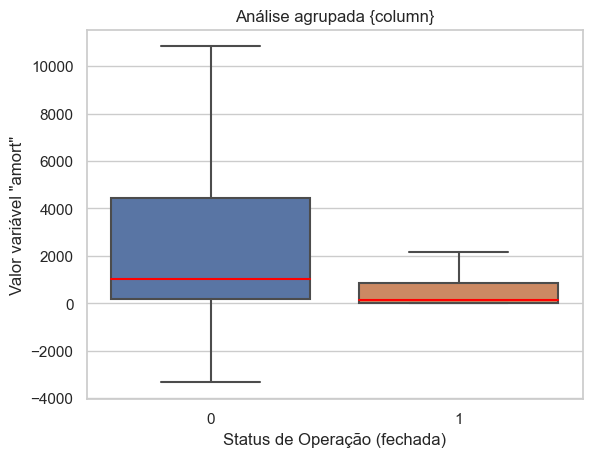

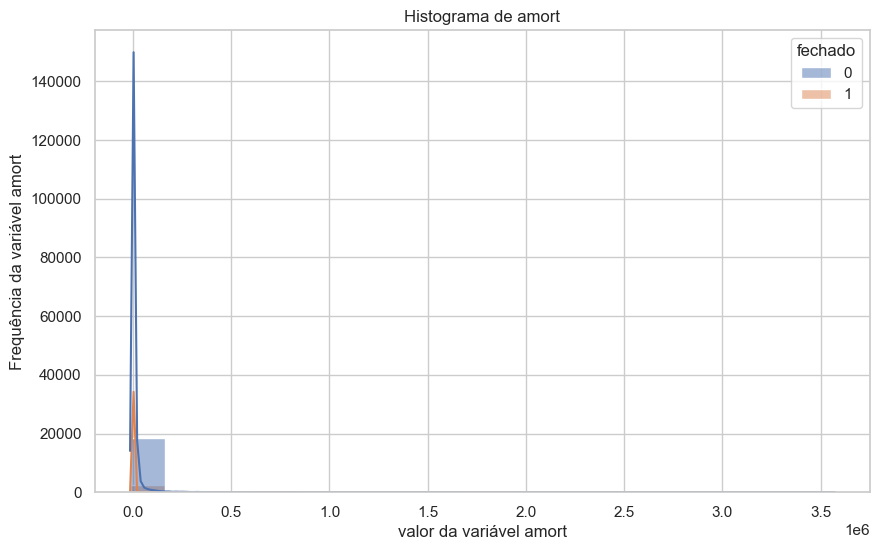

In [69]:
group_box("amort")
group_hist("amort")

Vamos converter para log para conseguirmos analisar melhor as tendências

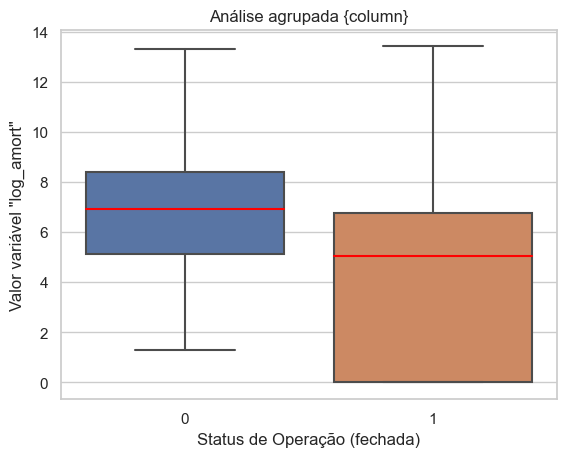

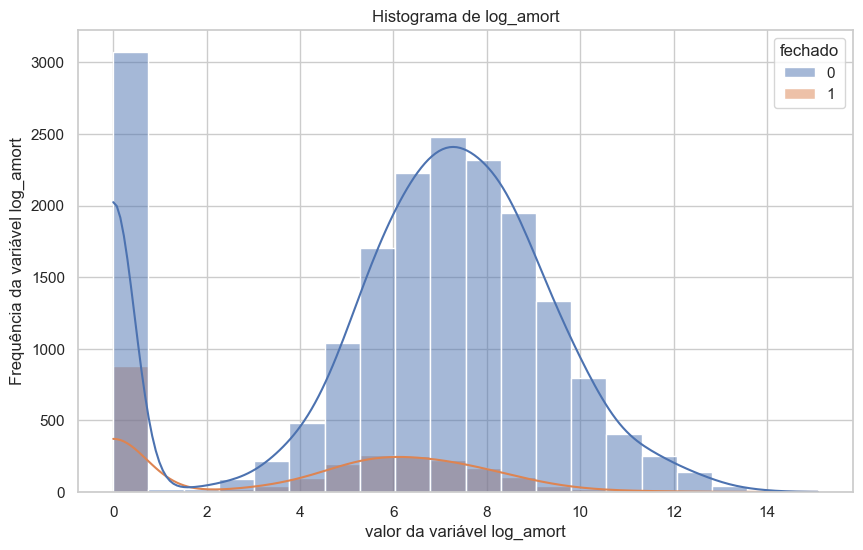

In [70]:
criar_log(data_2012, "amort")

group_box("log_amort")
group_hist("log_amort")

O logarítmo da amortização tem distribuição aparentemente normal com cauda à esquerda tanto para as empresas abertas quanto para as fechadas. A distribuição para as empresas abertas tem centro maior do que as outras, sugerindo que um maior valor para o logarítmo da amortização pode indicar maior probabilidade de a empresa estar aberta.

Tendo confirmado uma distribuição mais razoavel para o logarítmo de amortizacção do que para a variável original, tiramos "amort" da base e deixamos "log_amort".

In [71]:
data_2012.drop(columns = "amort", inplace=True)

#### Indústria

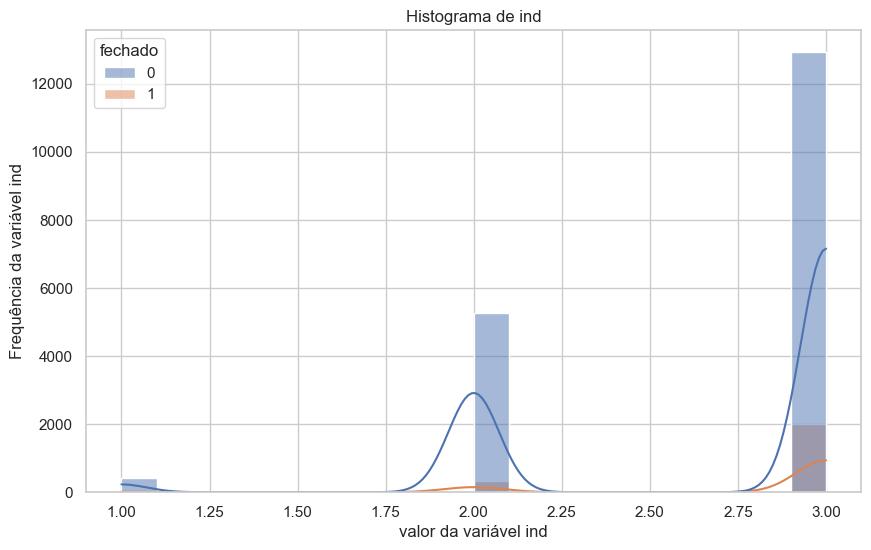

In [72]:
group_hist("ind")

A proporção de empresas fechadas parece se manter por indústria. Dadas as diferenças de escala na quantidade de empresas por indústria, conferimos essas proporções numericamente.

In [73]:
def proportion_1(column, data=data_2012):
    '''Funcao retorna proporcao de fechado para cada caso'''

    industry_effect = data_2012.groupby(["fechado", column])[column].count()

    pivot_table = data_2012.pivot_table(index=column, columns='fechado', aggfunc='size', fill_value=0)

    # calcular proporção
    pivot_table['Proportion'] = pivot_table[1] / (pivot_table[0] + pivot_table[1])

    # Reset the index to make 'ind' a regular column
    # Resetando index para fazer "ind" uma coluna normal
    pivot_table = pivot_table.reset_index()

    # Renomeando por clareza
    pivot_table.columns = [column, '0_Count', '1_Count', 'Proporcao_1']

    return pivot_table

In [74]:
print(proportion_1("ind"))

   ind  0_Count  1_Count  Proporcao_1
0  1.0      416       29          0.1
1  2.0     5272      319          0.1
2  3.0    12925     1991          0.1


A analise dos números confirma proporcoes aproximadamente iguais de empresas fechadas para abertas por indústria, indicando baixo poder de previsão dessa variável. Por isso retiramos da base as duas variáveis referentes à industria.

In [75]:
data_2012.drop(columns = ["ind","ind2"], inplace=True)

Agora vamos ordenar por significancia nossas variáveis e verificar os resultados:

Variáveis como "comp_id" número da impressa não deveriam interferir na predição pois são valores arbitrarios de registro de cada empresa.

## Exportação da base tratada para modelagem

In [83]:
data_2012.to_csv("data_2012.csv", index=False)
data_2012_num.to_csv("data_2012_numerical.csv", index=False)

In [84]:
data_2012.columns

Index(['comp_id', 'curr_assets', 'curr_liab', 'extra_exp', 'extra_inc',
       'extra_profit_loss', 'fixed_assets', 'inc_bef_tax', 'intang_assets',
       'inventories', 'liq_assets', 'material_exp', 'personnel_exp',
       'profit_loss_year', 'sales', 'share_eq', 'subscribed_cap',
       'tang_assets', 'balsheet_flag', 'balsheet_length',
       'balsheet_notfullyear', 'founded_year', 'ceo_count', 'foreign',
       'female', 'birth_year', 'inoffice_days', 'nace_main', 'urban_m',
       'labor_avg', 'gender', 'origin', 'region_m', 'fechado', 'log_sales',
       'company_age', 'current_ratio', 'profit_margin', 'debt_equity_ratio',
       'asset_turnover', 'log_amort'],
      dtype='object')

In [85]:
data_2012_num.columns

Index(['comp_id', 'curr_assets', 'curr_liab', 'extra_exp', 'extra_inc',
       'extra_profit_loss', 'fixed_assets', 'inc_bef_tax', 'intang_assets',
       'inventories', 'liq_assets', 'material_exp', 'personnel_exp',
       'profit_loss_year', 'sales', 'share_eq', 'subscribed_cap',
       'tang_assets', 'balsheet_flag', 'balsheet_length',
       'balsheet_notfullyear', 'founded_year', 'ceo_count', 'foreign',
       'female', 'birth_year', 'inoffice_days', 'nace_main', 'urban_m',
       'labor_avg', 'fechado', 'log_sales', 'company_age', 'current_ratio',
       'profit_margin', 'debt_equity_ratio', 'asset_turnover', 'log_amort',
       'gender_female', 'gender_male', 'gender_mix', 'origin_Domestic',
       'origin_Foreign', 'origin_mix', 'region_m_Central', 'region_m_East',
       'region_m_West'],
      dtype='object')

In [86]:
#data_2012.to_excel("data_2012.xlsx")